## Accessing Sentinel-1 RTC data with the Planetary Computer STAC API

The [Sentinel 1 RTC](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc) product in this collection is a radiometrically terrain corrected product derived from the [Sentinel-1 Ground Range Detected (GRD)](https://planetarycomputer.microsoft.com/dataset/sentinel-1-grd) Level-1 products produced by the European Space Agency.

### Environment setup

Running this notebook requires an API key.

* The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.
* To use your API key locally, set the environment variable `PC_SDK_SUBSCRIPTION_KEY` or use `planetary_computer.settings.set_subscription_key(<YOUR API Key>)`

See [when an account is needed](https://planetarycomputer.microsoft.com/docs/concepts/sas/#when-an-account-is-needed) for more, and [request an account](http://planetarycomputer.microsoft.com/account/request) if needed.

In [1]:
import ipyleaflet
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pystac
import pystac_client
import planetary_computer
import requests
import rich.table

from IPython.display import Image

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Choose an area and time of interest

We'll search for assets acquired over Panama in the first week of May, 2022. You can use the [Planetary Computer Explorer](https://planetarycomputer.microsoft.com/explore?c=-79.6735%2C9.0461&z=9.91&ae=0&v=2&d=sentinel-1-rtc&s=false%3A%3A100%3A%3Atrue&m=Most+recent+-+VV%2C+VH&r=VV%2C+VH+False-color+composite) to find areas of interest.

In [3]:
bbox = [149.34, -37.2, 150.00, -36.9]
search = catalog.search(
    collections=["sentinel-1-rtc"], bbox=bbox, datetime="2020-02-07/2020-02-28"
)
items = search.item_collection()
print(f"Found {len(items)} items")
item = items[0]

Found 3 items


The `rendered_preview` asset lets us quickly visualize the data. For Seninel-1 RTC, this produces a false-color composite from a combination of the VV and VH bands.

In [4]:
Image(url=item.assets["rendered_preview"].href)

### Inspect the STAC metadata

The STAC metadata includes many useful pieces of metadata, including metadata from the [SAR](https://github.com/stac-extensions/sar) and [Satellite](https://github.com/stac-extensions/sat) extensions.

In [5]:
table = rich.table.Table("key", "value")
for k, v in sorted(item.properties.items()):
    table.add_row(k, str(v))

table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ key                                   ┃ value                                                       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ constellation                         │ Sentinel-1                                                  │
│ datetime                              │ 2020-02-22T19:16:51.140395Z                                 │
│ end_datetime                          │ 2020-02-22 19:17:03.639428+00:00                            │
│ platform                              │ SENTINEL-1A                                                 │
│ proj:bbox                             │ [538420.0, 5744380.0, 845300.0, 5990560.0]                  │
│ proj:epsg                             │ 32755                                                       │
│ proj:shape                            │ [24618, 30688]                                              │
│ proj:transform                        │ [10.0, 0.0, 538420.0, 0.0, -10.0, 5990560.0, 0.0, 0.0, 1.0] │
│ s1:datatake_id                        │ 236614                                                      │
│ s1:instrument_configuration_ID        │ 6                                                           │
│ s1:orbit_source                       │ RESORB                                                      │
│ s1:processing_level                   │ 1                                                           │
│ s1:product_timeliness                 │ Fast-24h                                                    │
│ s1:resolution                         │ high                                                        │
│ s1:shape                              │ [30688, 24618]                                              │
│ s1:slice_number                       │ 12                                                          │
│ s1:total_slices                       │ 16                                                          │
│ sar:center_frequency                  │ 5.405                                                       │
│ sar:frequency_band                    │ C                                                           │
│ sar:instrument_mode                   │ IW                                                          │
│ sar:looks_azimuth                     │ 1                                                           │
│ sar:looks_equivalent_number           │ 4.4                                                         │
│ sar:looks_range                       │ 5                                                           │
│ sar:observation_direction             │ right                                                       │
│ sar:pixel_spacing_azimuth             │ 10                                                          │
│ sar:pixel_spacing_range               │ 10                                                          │
│ sar:polarizations                     │ ['VV', 'VH']                                                │
│ sar:product_type                      │ GRD                                                         │
│ sar:resolution_azimuth                │ 22                                                          │
│ sar:resolution_range                  │ 20                                                          │
│ sat:absolute_orbit                    │ 31369                                                       │
│ sat:orbit_state                       │ descending                                                  │
│ sat:platform_international_designator │ 2014-016A                                                   │
│ sat:relative_orbit                    │ 147                                                         │
│ start_datetime                        │ 2020-02-22 19:16:38.641362+00:00                            │
└───────────────────────────────────────┴───────

The data assets on every Sentinel-1 RTC item will be some combination of `hh`, `hv`, `vh`, and `vv`. These represent the terrain-corrected gamma nought values of a signal transmitted in one polarization ("h" or "v") and received in another ("h" or "v"). The `sar:polarizations` field indicates which assets are available.

In [6]:
item.properties["sar:polarizations"]

['VV', 'VH']

### Visualize the assets

Next, we'll load the `vv` data into [xarray](https://xarray.pydata.org/) and plot the results. We'll use [Dask](http://dask.org/) to load the data in parallel. We're working with a small amount of data so we'll use a single machine. For larger datasets, see [Scaling with Dask](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/).

In [7]:
from distributed import Client

client = Client(processes=False)
print(client.dashboard_link)

/user/jane.kennedy10@uon.edu.au/proxy/8787/status


In [8]:
import stackstac

ds = stackstac.stack(items, bounds_latlon=bbox, epsg=32630, resolution=100)
ds

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-f57203351cab4af27ee1057d99fbdad8' (time: 3,
                                                                band: 2,
                                                                y: 530, x: 710)>
dask.array<fetch_raster_window, shape=(3, 2, 530, 710), dtype=float64, chunksize=(1, 1, 530, 710), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                   (time) datetime64[ns] 2020-02-10T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDV_2020...
  * band                                   (band) <U2 'vh' 'vv'
  * x                                      (x) float64 2.918e+06 ... 2.989e+06
  * y                                      (y) float64 -1.55e+07 ... -1.555e+07
    end_datetime                           (time) <U32 '2020-02-10 19:17:03.8...
    ...                                     ...
    start_datetime                         (time) <U32 '2020-02-10 19:16:38.8...
    s1:slice_number                        (time) <U2 '12' '9' '12'
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            (band) <U173 'Terrain-corrected ga...
    title                                  (band) <U41 'VH: vertical transmit...
    epsg                                   int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(2917800, -15553300, 2988800, ...
    crs:         epsg:32630
    transform:   | 100.00, 0.00, 2917800.00|\n| 0.00,-100.00,-15500300.00|\n|...
    resolution:  100

We'll select the `vv` band for the first timestep found by our search.

In [9]:
#vv = ds.sel(band="vv")[0].compute()
vv = ds.sel(band="vv").compute()


The distribution of the raw values is quite skewed:

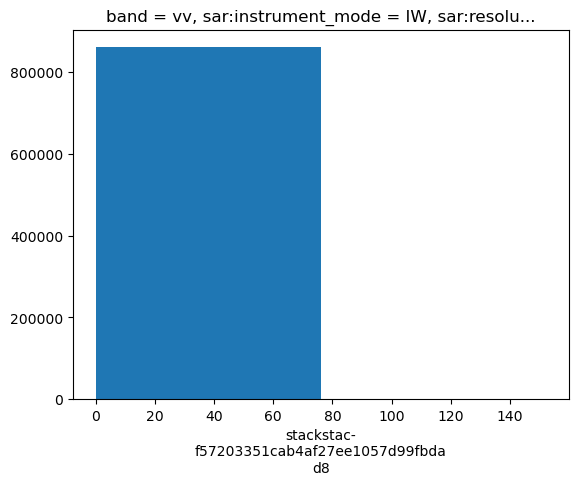

In [10]:
vv.plot.hist(bins=2);

So the values are typically transformed before visualization:

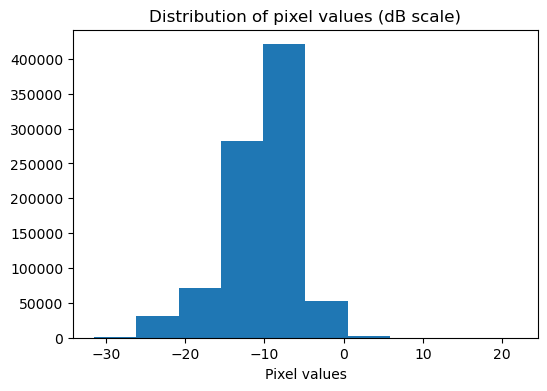

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))


def db_scale(x):
    return 10 * np.log10(x)


db_scale(vv).plot.hist(bins=10, ax=ax)
ax.set(title="Distribution of pixel values (dB scale)", xlabel="Pixel values");

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/srv/conda/envs/notebook/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


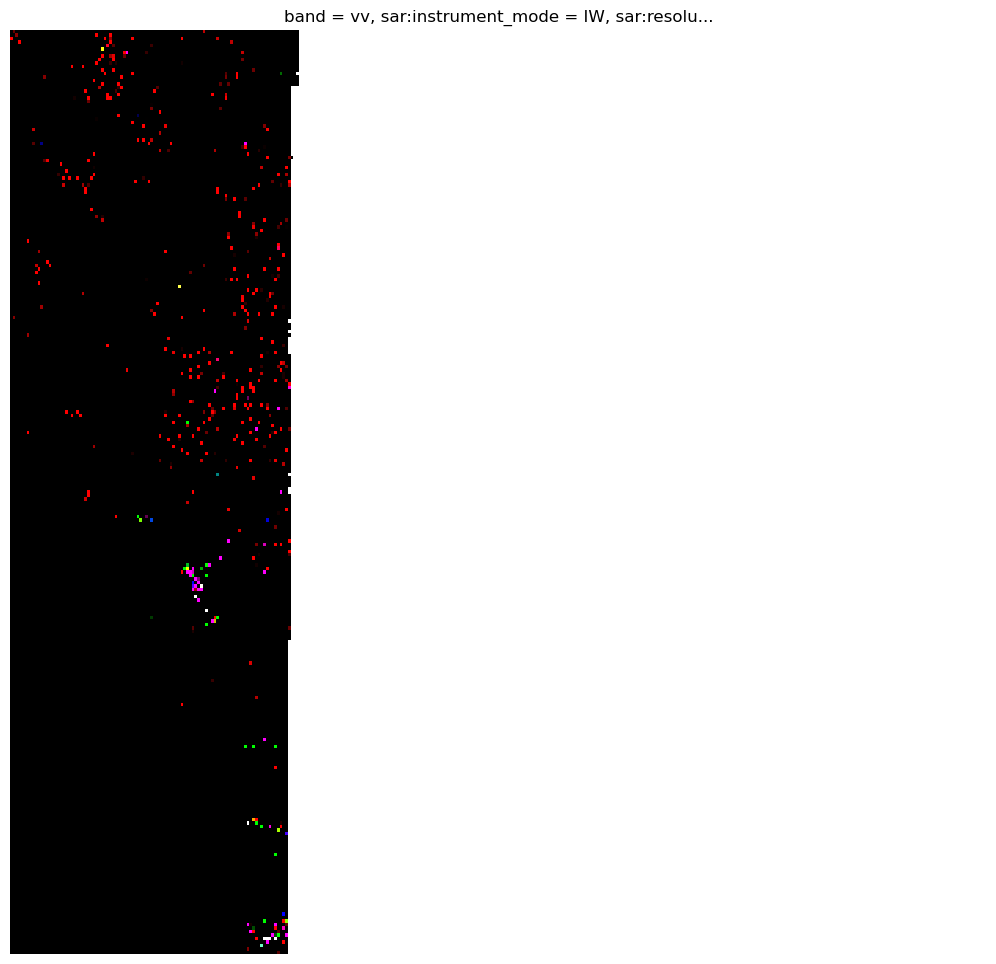

In [12]:
img = (
    db_scale(vv)
    .coarsen(x=2, y=2, boundary="trim")
    .max()
    .plot.imshow(cmap="bone", size=12, aspect=1.05, add_colorbar=False)
)
img.axes.set_axis_off();

In [13]:
import rioxarray
import rasterio
#visualise assets
vv = (
    rioxarray.open_rasterio(item.assets["vv"].href, overview_level=2)
    .astype(float)
    .squeeze()
)
vh = (
    rioxarray.open_rasterio(item.assets["vh"].href, overview_level=2)
    .astype(float)
    .squeeze()
)

In [14]:
import pandas as pd
import seaborn as sns

raw = vv.where(lambda x: x > 0).data.ravel()
df = (
    pd.DataFrame({"power": raw, "amplitude": np.sqrt(raw), "dB": 10 * np.log10(raw)})
    .dropna()
    .melt(value_vars=["power", "amplitude", "dB"], var_name="kind")
)

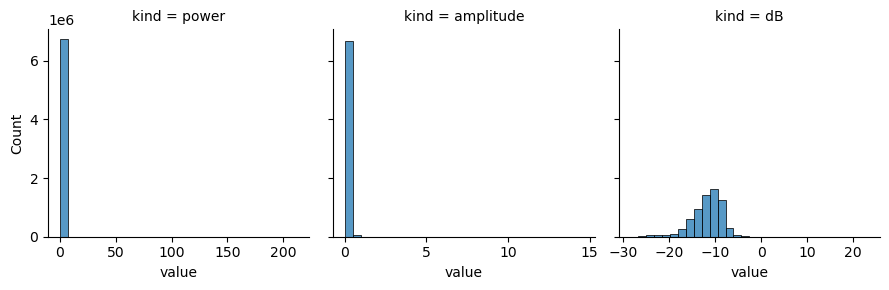

In [15]:
g = sns.FacetGrid(df, sharex=False, col="kind")
g.map(sns.histplot, "value", bins=30);

/srv/conda/envs/notebook/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


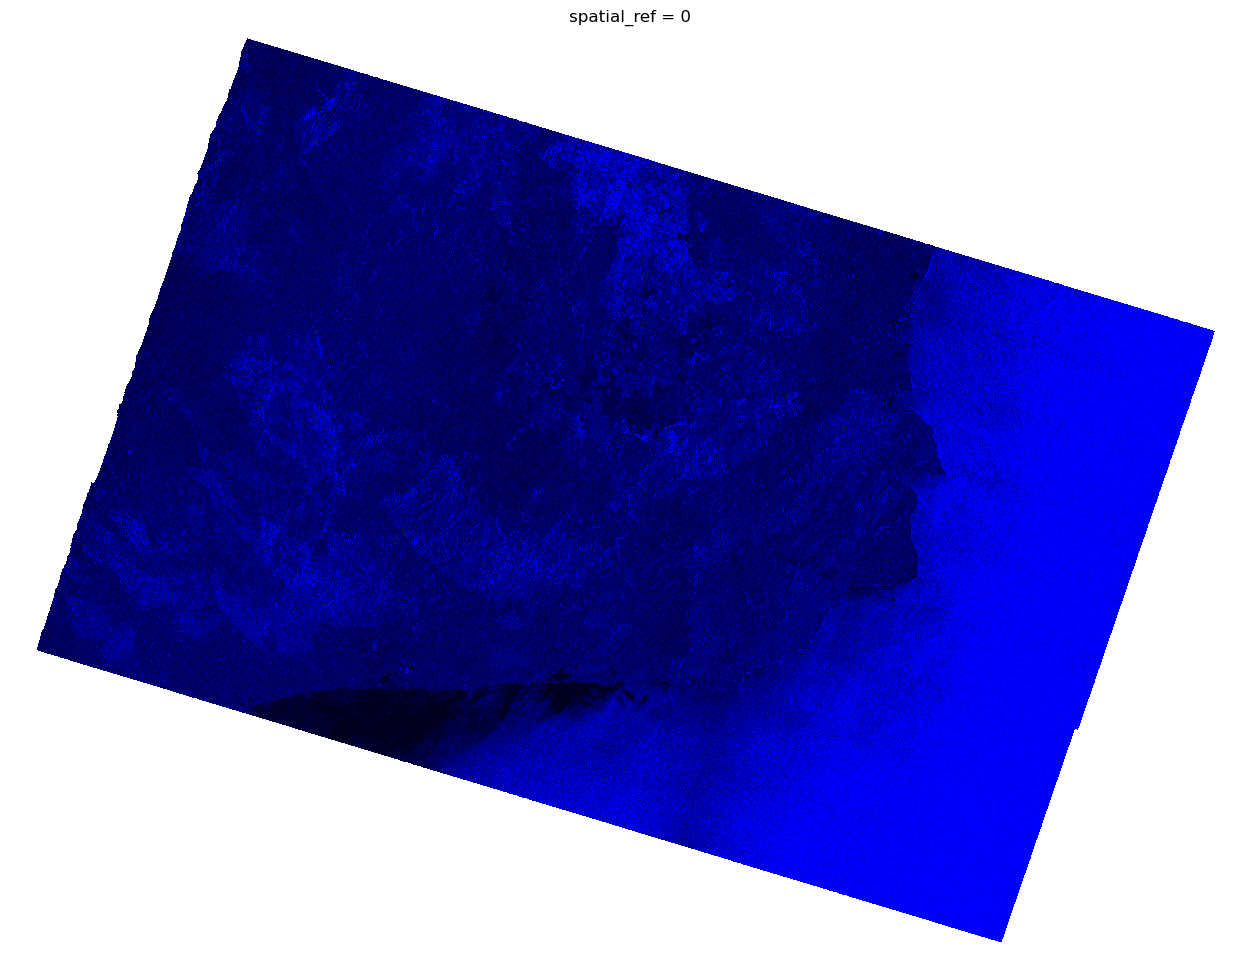

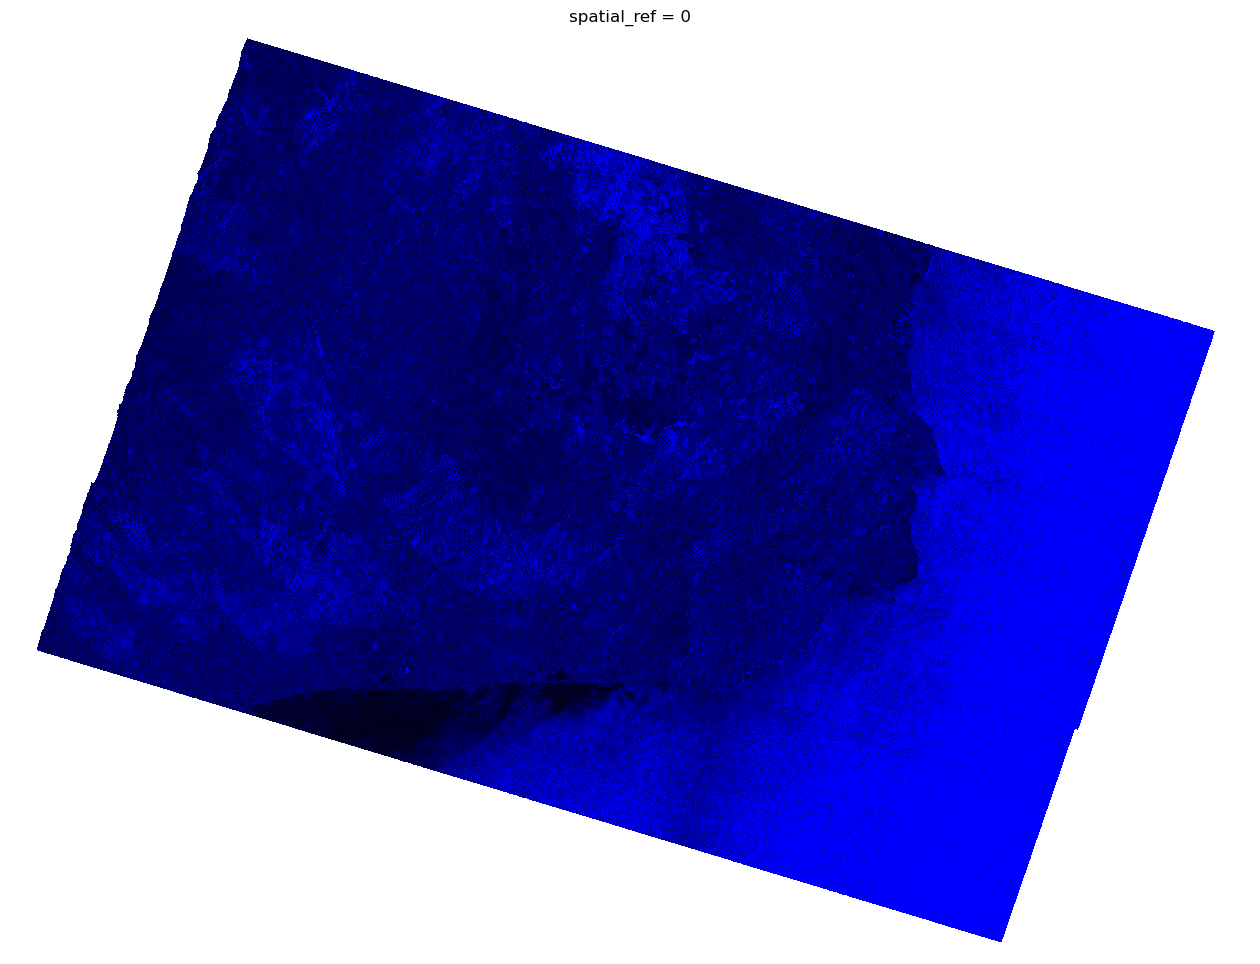

In [16]:
r = vv / 600
g = vh / 270
b = (vv / vh) / 9
data = xr.concat([r, g, b], dim="band").clip(0, 1).where(lambda x: x > 0)
img = data.plot.imshow(rgb="band", size=12)
img.axes.set_axis_off()

#flip image insert from grd notebook fix... 
img = np.flip(data, axis=(1, 2)).clip(0, 1).plot.imshow(size=12)
img.axes.set_axis_off()

In [17]:
img



In [18]:

def compute_otsu_criteria(im, th):
    """Otsu's method to compute criteria."""
    # create the thresholded image
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1

    # compute weights
    nb_pixels = im.size
    nb_pixels1 = np.count_nonzero(thresholded_im)
    weight1 = nb_pixels1 / nb_pixels
    weight0 = 1 - weight1

    # if one of the classes is empty, eg all pixels are below or above the threshold, that threshold will not be considered
    # in the search for the best threshold
    if weight1 == 0 or weight0 == 0:
        return np.inf

    # find all pixels belonging to each class
    val_pixels1 = im[thresholded_im == 1]
    val_pixels0 = im[thresholded_im == 0]

    # compute variance of these classes
    var1 = np.var(val_pixels1) if len(val_pixels1) > 0 else 0
    var0 = np.var(val_pixels0) if len(val_pixels0) > 0 else 0

    return weight0 * var0 + weight1 * var1

Otsu_Img = np.random.randint(0,255, size = (50,50))
# load your image as a numpy array.
# For testing purposes, one can use for example im = np.random.randint(0,255, size = (50,50))

# testing all thresholds from 0 to the maximum of the image
threshold_range = range(np.max(Otsu_Img)+1)
criterias = [compute_otsu_criteria(Otsu_Img, th) for th in threshold_range]

# best threshold is the one minimizing the Otsu criteria
best_threshold = threshold_range[np.argmin(criterias)]

In [19]:
best_threshold


126

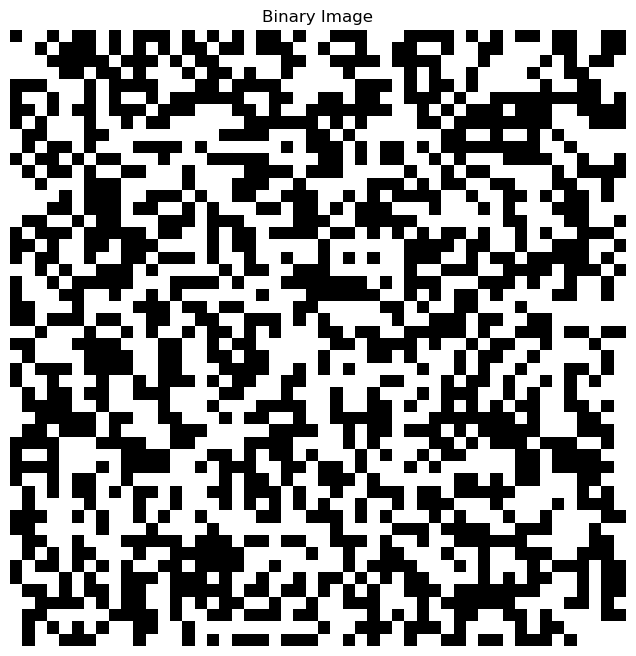

In [24]:


# Create a binary image based on the best threshold
binary_image = np.zeros(Otsu_Img.shape, dtype=np.uint8)
binary_image[Otsu_Img >= best_threshold] = 255  # Set pixels above the threshold to 255 (white)

# Now you have a binary image where pixels above the threshold are white (255) and below the threshold are black (0).

import matplotlib.pyplot as plt

# Define the resolution in inches (width, height)
figure_resolution = (10, 8)  # Change the values to your desired resolution

# Create a figure with the specified resolution
plt.figure(figsize=figure_resolution)

# Display the binary image
plt.imshow(binary_image, cmap='gray')  # Use 'gray' colormap for binary images
plt.title('Binary Image')
plt.axis('off')  # Turn off the axis labels
plt.show()



In [21]:
#Wtf happened up there ^
# Examine an arbitrary image NEED TO CREATE GEOTIFF AND MAP ??
image_path = FEATURE_PATH / f"{train_metadata.image_id[0]}.tif"

with rasterio.open(image_path) as img:
    metadata = img.meta
    bounds = img.bounds
    data = img.read(1)  # read a single band

metadata
    
    # Load water mask

with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    # Mask missing data and 0s for visualization
label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    # Visualize water label
ax[1].imshow(s1_img)
ax[1].imshow(label, cmap="cool", alpha=1)
ax[1].set_title("S1 Chip with Water Label", fontsize=14)

plt.tight_layout(pad=5)
plt.show()

NameError: name 'FEATURE_PATH' is not defined

### The effect of terrain correction

In this section, we compare Sentinel-1 GRD to Sentinel-1 RTC to see the effect of terrain correction.

Every Sentinel-1-RTC item is derived from a [Sentinel-1-GRD](https://planetarycomputer.microsoft.com/dataset/sentinel-1-grd) item. You can follow the `derived_from` link to get back to the original GRD item.

In [ ]:
rtc_item = catalog.get_collection("sentinel-1-rtc").get_item(
    "S1A_IW_GRDH_1SDV_20200222T191638_20200222T191703_031369_039C46_rtc"
)
grd_item = pystac.read_file(rtc_item.get_single_link("derived_from").target)

Next, we'll use the `tilejson` asset, which uses the Planetary Computer's [Data API](https://planetarycomputer.microsoft.com/api/data/v1/) to serve xyz tiles for a STAC item.

In [ ]:
grd_tiles = requests.get(grd_item.assets["tilejson"].href).json()["tiles"][0]
rtc_tiles = requests.get(rtc_item.assets["tilejson"].href).json()["tiles"][0]

With these URLs, we can build an interactive map using [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/index.html). Adjust the slider to visualize either GRD (to the left) or RTC (to the right).

In [ ]:
center = [149.75, -37.0]
m = ipyleaflet.Map(
    center=center,
    zoom=14,
    controls=[ipyleaflet.FullScreenControl()],
)
grd_layer = ipyleaflet.TileLayer(url=grd_tiles)
rtc_layer = ipyleaflet.TileLayer(url=rtc_tiles)

control = ipyleaflet.SplitMapControl(left_layer=grd_layer, right_layer=rtc_layer)
m.add_control(control)
m.scroll_wheel_zoom = True
m

Notice that points seem to "jump" between the GRD and RTC. The RTC values are corrected to align with where they're actually at on the Earth.

For more background on terrain correction, and for an introduction to the [sarsen](https://github.com/bopen/sarsen) package which enables customizable RTCs, see [Sentinel-1 Customizable Radiometric Terrain Correction](https://planetarycomputer.microsoft.com/docs/tutorials/customizable-rtc-sentinel1/).